In [99]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display # to display images
import torchvision as thv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch

## Q2

In [100]:
def shuffle_dataset(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], Y[indices]

def subsample(dataset, num_samples, num_classes):
    X = dataset.data.numpy()

    # flatten X and change type
    X = X.reshape(X.shape[0], -1).astype(np.float32)

    Y = np.array(dataset.targets)

    # final size of each class
    class_size = int(num_samples / 10)
    indices = []

    for label in range(num_classes):
        # find indices for the given label and select the first class_size elements
        label_indices = np.argwhere(Y == label)[:class_size].flatten()
        indices.extend(label_indices)

    indices = np.array(indices)
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    # normalize x
    sampled_X = sampled_X / 255.0

    return sampled_X, sampled_Y

def batch_generator(X, Y, batch_size):
    while True:
        X, Y = shuffle_dataset(X, Y)
        for i in range((X.shape[0] - batch_size) // batch_size):
            yield X[i * batch_size: i * batch_size + batch_size], Y[i * batch_size: i * batch_size + batch_size]

np.random.seed(20)

# load dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)

trainX, trainY = subsample(dataset=train, num_samples=10*1000, num_classes=10)
valX, valY = subsample(dataset=val, num_samples=500*10, num_classes=10)

In [101]:
def resize_images(df, old, new):
    df_temp = df
    num_samples = df_temp.shape[0]
    df_temp = df_temp.reshape((num_samples, old, old))
    downsized = np.zeros((num_samples, new, new))
    for ix in range(num_samples):
        downsized[ix] = cv2.resize(df_temp[ix], (new, new))
        _, downsized[ix] = cv2.threshold(downsized[ix]*255,127,255,cv2.THRESH_BINARY)
    downsized = downsized.reshape((num_samples, new**2))
    return downsized

In [102]:
resized_train_x = resize_images(trainX, 28, 14)
resized_val_x = resize_images(valX, 28, 14)

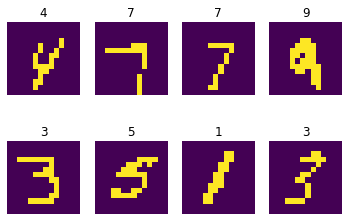

In [103]:
fig, axs = plt.subplots(2, 4)
index = np.random.randint(len(trainX), size=8)
i = 0

for r in range(2):
    for c in range(4):
        axs[r, c].imshow(resized_train_x[index[i]].reshape(14, 14))
        axs[r, c].set_title(str(trainY[index[i]]))
        axs[r, c].axis('off')
        i+=1

In [104]:
train_dataloader = batch_generator(resized_train_x, trainY, batch_size=64)
val_dataloader = batch_generator(resized_val_x, valY, batch_size=64)

1. Two fully-connected layers
    - first has 196 inputs and 128 outputs + tanh nonlinearity
    - second has 128 inputs and 16 outputs + no nonlinearity
1. Decoder takes as an input z, pushes it through:
    - one layer with 128 outputs + tanh nonlinearity
    - another layer with 196 output neurons + sigmoid nonlinearity

In [112]:
def KL(mu, sigma):
    runningKL = 0
    for i in range(8):
        contribution = 1 + torch.log(sigma[i]**2) - mu[i]**2 - sigma[i]**2
        runningKL += -torch.sum(contribution)/2
    return runningKL/mu.shape[0]

def loss(x, mu, sigma, y):
#     print("x ", x)
#     print("y ", y)
    kl_loss = KL(mu, sigma)
    bce = nn.BCELoss()(y, x)
    print('kl: ', kl_loss, 'bce: ', bce)
    return kl_loss + bce

In [78]:
# def loss(x, mu, sigma, y):
#     # how well do input x and output recon_x agree?
#     BCE = nn.BCELoss()(y, x.reshape((x.shape[0], -1)))

#     # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = 0
#     for i in range(8):
#         KLD += torch.sum((1 + torch.log(sigma[i]**2) - mu[i]**2 - sigma[i]**2)) / (-2)
    
#     # Normalise by same number of elements as in reconstruction
#     KLD /= mu.shape[0]

#     # BCE tries to make our reconstruction as accurate as possible
#     # KLD tries to push the distributions as close as possible to unit Gaussian  
#     return BCE + KLD

In [106]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 16)

    def forward(self, x):
        reshaped = x.reshape(x.shape[0], -1)
        out = torch.tanh(self.fc1(reshaped))
        out = self.fc2(out)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 196)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        return out

In [107]:
lr = 0.001

encoder = Encoder()
encoder_optimzation = optim.Adam(enc.parameters(), lr = lr)

decoder = Decoder()
decoder_optimzation = optim.SGD(dec.parameters(), lr = lr)

In [108]:
train_error_list, train_loss_list, val_error_list, val_loss_list = [], [], [], []

In [113]:
for t in range(1000):
    # 1. sample a mini-batch of size bb = 32
    x, y = train_dataloader.__next__()

    x = torch.Tensor(x)
    y = torch.Tensor(y)

    encoder_optimzation.zero_grad()
    decoder_optimzation.zero_grad()

    encoding = encoder(x)
    mu       = encoding[:, :8]
    sigma    = encoding[:, 8:]
    decoding = decoder(mu)

    total_loss = loss(x.reshape((x.shape[0], -1)), mu, sigma, decoding)
    total_loss.backward()

    encoder_optimzation.step()
    decoder_optimzation.step()

    train_loss_list.append(total_loss.item())
    
    if t % 100 == 0:
        print(t, total_loss.item())

kl:  tensor(1.0931, grad_fn=<DivBackward0>) bce:  tensor(-0.1379, grad_fn=<BinaryCrossEntropyBackward>)
0 0.9551087617874146
kl:  tensor(1.0965, grad_fn=<DivBackward0>) bce:  tensor(0.0595, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(0.9923, grad_fn=<DivBackward0>) bce:  tensor(-0.0025, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(1.3051, grad_fn=<DivBackward0>) bce:  tensor(0.0504, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(0.9445, grad_fn=<DivBackward0>) bce:  tensor(-0.0195, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(0.9002, grad_fn=<DivBackward0>) bce:  tensor(-0.0120, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(0.8418, grad_fn=<DivBackward0>) bce:  tensor(-0.0623, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(1.0203, grad_fn=<DivBackward0>) bce:  tensor(-0.0686, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(1.1109, grad_fn=<DivBackward0>) bce:  tensor(-0.0160, grad_fn=<BinaryCrossEntropyBackward>)
kl:  tensor(1.0348, grad_fn=<DivBackward0>) b

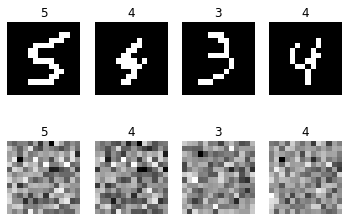

In [98]:
fig, axs = plt.subplots(2, 4)

num_samples = 4
index = np.random.randint(len(resized_val_x), size=8)
i = 0

# for r in range(2):
for c in range(num_samples):
    x = resized_val_x[index[i]]
    axs[0, c].imshow(x.reshape(14, 14), cmap=plt.cm.gray)
    axs[0, c].set_title(str(valY[index[i]]))
    axs[0, c].axis('off')
    
    x = torch.Tensor(x).unsqueeze(0)
    encoding = encoder(x)
    mu = encoding[:, :8]
    sigma = encoding[:, 8:]
    decoding = decoder(mu).reshape((14, 14)).detach().numpy()

    axs[1, c].imshow(decoding, cmap=plt.cm.gray)
    axs[1, c].set_title(str(valY[index[i]]))
    axs[1, c].axis('off')
    i+=1
plt.show()    

In [ ]:
for t in range(1000):
    x, y = train_dataloader.__next__()
    x = torch.Tensor(x)
    y = torch.Tensor(y).long()
    
    enc_optim.zero_grad()
    dec_optim.zero_grad()
    
    encoding = enc(x)
    mu    = encoding[:,  :8]
    sigma = encoding[:, 8: ]
    decoding = dec(x)
    
    kl = loss(x, mu, sigma, decoding)
    kl.backward()

    enc_optim.step()
    dec_optim.step()
    
    print(t, total_loss.item())
    train_loss_list.append(total_loss.item())